In [1]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)       # show up to 50 rows
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 200)         # wider display
pd.set_option('display.max_colwidth', None) # full column content


import matplotlib.pyplot as plt


In [2]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')



In [3]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [4]:
matches.head(2)

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri


In [5]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    df = df.rename(columns={'batter': 'batsman'})
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [6]:
df = playerStatistics(deliveries)

In [7]:

df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Badoni,35,634,505,26,183,201,48,3,46,24,125.544554,18.114286,19.423077,7.214286
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000


In [8]:
def phase(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle'
    else:
        return 'Death'

In [9]:

deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [10]:
def phasesOfplay(df, current_phase):
    df = df.rename(columns={'batter': 'batsman'})
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [11]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')


In [12]:
pp_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.000000,7.000000,7.000000
1,A Badoni,7,29,47,3,28,15,1,0,3,0,61.702128,4.142857,15.666667,15.666667


In [13]:
mid_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,8,83,60,3,21,23,7,0,4,5,138.333333,10.375000,20.000000,6.666667
1,A Badoni,23,273,246,9,91,107,21,0,19,8,110.975610,11.869565,27.333333,9.111111


In [14]:
dth_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,19,192,129,11,35,59,13,1,11,10,148.837209,10.105263,11.727273,6.142857
1,A Badoni,23,332,212,14,64,79,26,3,24,16,156.603774,14.434783,15.142857,5.300000


In [15]:
def ByInning(df, current_inning):
    df = df.rename(columns={'batter': 'batsman'})
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [16]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [17]:
ing1_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,13,166,115,7,32,53,13,1,6,10,144.347826,12.769231,16.428571,7.187500
1,A Badoni,19,464,338,13,109,140,33,2,36,18,137.278107,24.421053,26.000000,6.259259


In [18]:
ing2_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,10,114,81,8,29,30,7,0,10,5,140.740741,11.400,10.125000,5.4000
1,A Badoni,16,170,167,13,74,61,15,1,10,6,101.796407,10.625,12.846154,10.4375


In [19]:
comp = ing1_df[['batsman', 'RPI']].merge(ing2_df[['batsman', 'RPI']], on = 'batsman', how = 'inner').rename(columns = {'RPI_x':'1st_RPI', 'RPI_y':'2nd_RPI' })
comp.head(2)

,batsman,1st_RPI,2nd_RPI
0,A Ashish Reddy,12.769231,11.400
1,A Badoni,24.421053,10.625


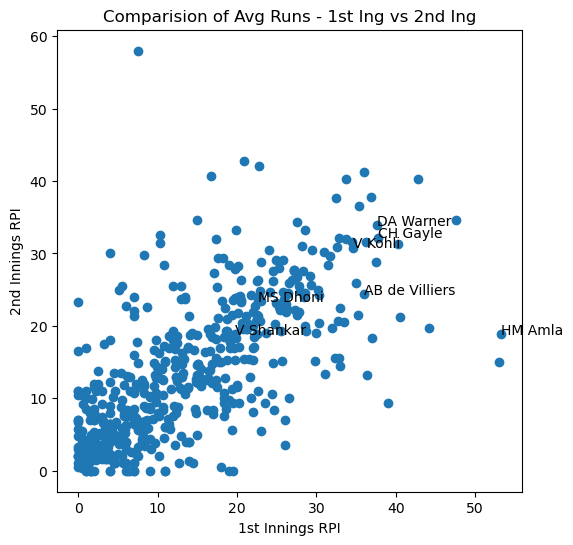

In [20]:
plt.figure(figsize = (6, 6))
plt.scatter(comp['1st_RPI'], comp['2nd_RPI'] )
plt.xlabel('1st Innings RPI')
plt.ylabel('2nd Innings RPI')
plt.title('Comparision of Avg Runs - 1st Ing vs 2nd Ing')

annotations=list(comp['batsman'])
selected_players = ['CH Gayle', 'V Kohli', 'AB de Villiers', 'DA Warner', 'V Shankar', 'HM Amla', 'MS Dhoni']

for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (comp['1st_RPI'][i], comp['2nd_RPI'][i]))
    
    
plt.show()


In [21]:
comp[comp['1st_RPI'] > 50]

,batsman,1st_RPI,2nd_RPI
170,HM Amla,53.25,18.875
238,Kamran Akmal,53.00,15.000


In [22]:
def ByOpposition(df, current_opposition):
    df = df.rename(columns={'batter': 'batsman'})
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    # StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    # runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    # balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [23]:
ByOpposition(deliveries, 'Royal Challengers Bangalore').head(3)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,5,55,42,4,15,19,2,0,2,4,130.952381,11.000000,10.500000,7.000000
1,A Badoni,3,47,53,3,26,19,2,0,6,0,88.679245,15.666667,17.666667,8.833333
2,A Chandila,1,4,6,0,2,4,0,0,0,0,66.666667,4.000000,6.000000,6.000000


In [24]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,phase
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,Powerplay
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN,Powerplay


In [25]:
selected_player = 'V Kohli'
deliveries = deliveries.rename(columns={'batter': 'batsman'})


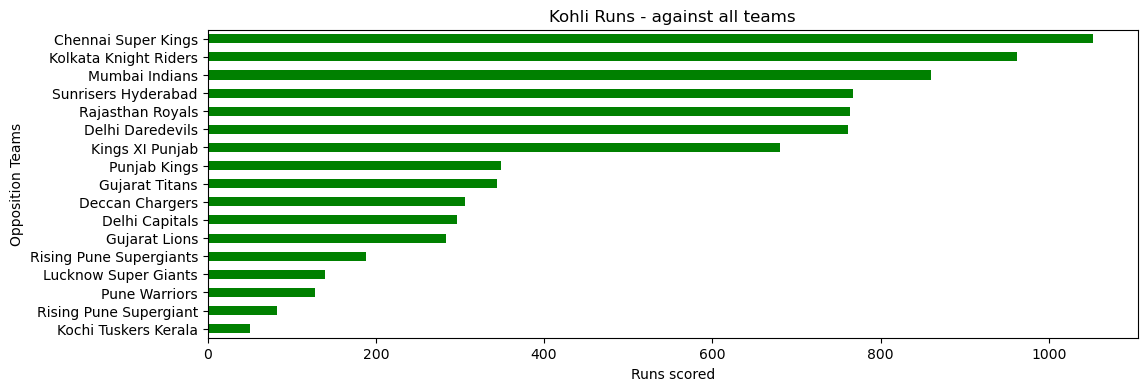

In [26]:
plt.figure(figsize = (12, 4))
deliveries[deliveries.batsman == selected_player].groupby(['bowling_team'])['batsman_runs'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Kohli Runs - against all teams')
plt.xlabel('Runs scored')
plt.ylabel('Opposition Teams')
plt.show()

In [27]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False
            

In [28]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)
matches[['id', 'season', 'team1', 'team2', 'wintoss_winmatch']].head()

,id,season,team1,team2,wintoss_winmatch
0,335982,2007/08,Royal Challengers Bangalore,Kolkata Knight Riders,True
1,335983,2007/08,Kings XI Punjab,Chennai Super Kings,False
2,335984,2007/08,Delhi Daredevils,Rajasthan Royals,True
3,335985,2007/08,Mumbai Indians,Royal Challengers Bangalore,False
4,335986,2007/08,Kolkata Knight Riders,Deccan Chargers,True


In [29]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 52.32876712328767


In [30]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

def venueAnalysis(mdf, df):
    
    runs = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index())
    runs['Id_Ing'] = runs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    balls = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].count().reset_index()).rename(columns = {'total_runs':'total_balls'})
    balls['Id_Ing'] = balls.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df['isOut'] = df['player_dismissed'].apply(lambda x: isOut(x))
    outs = pd.DataFrame(df.groupby(['match_id', 'inning'])['isOut'].sum().reset_index()).rename(columns = {'isOut':'wickets'})
    outs['Id_Ing'] = outs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df = pd.merge(runs, balls[['Id_Ing', 'total_balls']], on = 'Id_Ing').merge(outs[['Id_Ing', 'wickets']], on = 'Id_Ing')
    
    mdf = mdf.rename(columns = {'id':'match_id'})
    df = pd.merge(df, mdf[['match_id', 'venue']], on = 'match_id')
    df = df[['match_id', 'venue', 'inning', 'total_runs', 'total_balls', 'wickets']]
    
    return df

In [31]:
ven_df = venueAnalysis(matches, deliveries)

In [32]:
ven_df.head()

,match_id,venue,inning,total_runs,total_balls,wickets
0,335982,M Chinnaswamy Stadium,1,222,124,3
1,335982,M Chinnaswamy Stadium,2,82,101,10
2,335983,"Punjab Cricket Association Stadium, Mohali",1,240,124,5
3,335983,"Punjab Cricket Association Stadium, Mohali",2,207,124,4
4,335984,Feroz Shah Kotla,1,129,122,8


In [33]:
pd.DataFrame(ven_df.groupby('venue')['total_runs'].mean().sort_values(ascending = False)).rename(columns = {'total_runs':'Avg_Runs'}).reset_index().head(10)

,venue,Avg_Runs
0,"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",200.000000
1,"Arun Jaitley Stadium, Delhi",190.343750
2,"Eden Gardens, Kolkata",190.156250
3,"M Chinnaswamy Stadium, Bengaluru",190.071429
4,"Himachal Pradesh Cricket Association Stadium, Dharamsala",189.375000
5,"Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",185.600000
6,"Rajiv Gandhi International Stadium, Uppal, Hyderabad",182.423077
7,Brabourne Stadium,174.050000
8,Punjab Cricket Association IS Bindra Stadium,173.800000
9,"Wankhede Stadium, Mumbai",173.188889


In [34]:
def ByVenue(df, current_venue):
    df = df.rename(columns={'batter': 'batsman'})
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [35]:
matches.rename(columns = {'id':'match_id'}, inplace = True)
combined_data = deliveries.merge(matches[['match_id', 'venue']], on = 'match_id', how = 'left')
combined_data.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,phase,isOut,venue
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN,Powerplay,0,M Chinnaswamy Stadium
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN,Powerplay,0,M Chinnaswamy Stadium


In [36]:
current_venue = 'MA Chidambaram Stadium'
df = ByVenue(combined_data, current_venue)
df.head(2)


,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Mishra,1,8,11,1,6,4,0,0,1,0,72.727273,8.0,11.0,11.0
1,AB de Villiers,1,9,10,1,4,3,3,0,0,0,90.000000,9.0,10.0,10.0


In [37]:
def ByCustom(df, current_venue, current_phase, current_opposition):
    
    df = df.rename(columns={'batter': 'batsman'})
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [38]:
df = ByCustom(combined_data, 'MA Chidambaram Stadium', 'Middle', 'Chennai Super Kings')
df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)
df.head()


,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
0,A Mishra,1,8,9,0,4,4,0,0,1,0,88.888889,8.0,9.0,9.000000,0.444444
1,AB de Villiers,1,2,2,1,1,0,1,0,0,0,100.000000,2.0,2.0,2.000000,0.500000
2,AD Russell,2,56,47,0,21,18,1,0,3,4,119.148936,28.0,47.0,6.714286,0.446809
3,AR Patel,1,9,9,1,3,5,0,0,1,0,100.000000,9.0,9.0,9.000000,0.333333
4,BA Stokes,1,25,17,0,2,9,5,0,0,1,147.058824,25.0,17.0,17.000000,0.117647


In [39]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = 0.13, 0.27, 0.16, 0.45
df = df[df.innings >= 2 ]

In [40]:
#step1: square of all values
df['calc_SR'] = df['SR'].apply(lambda x: x*x) 
df['calc_RPI'] = df['RPI'].apply(lambda x: x*x) 
df['calc_BPD'] = df['BPD'].apply(lambda x: x*x) 
df['calc_dot_percentage'] = df['dot_percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis = 0))

df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x/sq_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x/sq_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x*wt_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x*wt_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(df['calc_SR']), min(df['calc_SR'])
best_rpi, worst_rpi = max(df['calc_RPI']), min(df['calc_RPI'])
best_bpd, worst_bpd = max(df['calc_BPD']), min(df['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(df['calc_dot_percentage']), max(df['calc_dot_percentage'])

In [41]:
df['dev_best_SR'] = df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
df['dev_best_RPI'] = df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
df['dev_best_BPD'] = df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
df['dev_best_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))

df['dev_best_sqrt'] = df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis = 1) 

df['dev_worst_SR'] = df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
df['dev_worst_RPI'] = df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
df['dev_worst_BPD'] = df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
df['dev_worst_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))

df['dev_worst_sqrt'] = df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis = 1) 

In [42]:
df['score'] = df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)
df[['batsman', 'score']].head()

,batsman,score
2,AD Russell,0.999999
10,HH Pandya,0.060369
14,KD Karthik,0.510591
15,KH Pandya,0.000000


In [44]:


df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'dot_percentage', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(25)

,batsman,innings,runs,balls,dismissals,dot_percentage,score
0,AD Russell,2,56,47,0,0.446809,0.999999
1,KD Karthik,2,27,27,1,0.407407,0.510591
2,HH Pandya,2,8,12,0,0.583333,0.060369
3,KH Pandya,2,1,4,2,0.750000,0.000000
